In [26]:
from rdkit import Chem
from rdkit.Chem import MolToSmiles

reader1 = Chem.SmilesMolSupplier("../compounds_to_test/LOTUS_DB.smi", delimiter="\t")
mols = [mol for mol in reader1]
ids = [mol.GetProp("_Name") for mol in mols]
smiles=[MolToSmiles(mol) for mol in mols]

In [2]:
from deepmol.pipeline import Pipeline

best_pipeline = Pipeline.load("sm_predictor_pipeline_tpe/trial_485")

2023-07-16 13:33:09.552176: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-16 13:33:09.554836: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-16 13:33:09.606574: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-16 13:33:09.607363: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-16 13:33:10.271784: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
from tqdm import tqdm
bar = tqdm(total=len(smiles))

import numpy as np
from deepmol.datasets import SmilesDataset

predictions = []
last_i = 0

import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')

for i in range(10000, len(smiles), 10000):
    lotus_dataset = SmilesDataset(smiles=smiles[last_i:i], mols=mols[last_i:i], ids=ids[last_i:i])
    prediction = best_pipeline.predict(lotus_dataset)
    if i == 10000:
        predictions = prediction
    else:
        predictions = np.concatenate((predictions, prediction))

    last_i += 10000
    bar.update(10000)


lotus_dataset = SmilesDataset(smiles=smiles[last_i:], mols=mols[last_i:], ids=ids[last_i:])
prediction = best_pipeline.predict(lotus_dataset)
predictions = np.concatenate((predictions, prediction))

 98%|█████████▊| 270000/276517 [10:52<00:15, 412.90it/s]

In [5]:
lotus_dataset = SmilesDataset(smiles=smiles[last_i:], mols=mols[last_i:], ids=ids[last_i:])
prediction = best_pipeline.predict(lotus_dataset)
predictions = np.concatenate((predictions, prediction))

In [6]:
predictions.shape

(276517, 20)

In [7]:
import pickle

# open a file, where you ant to store the data
file = open('predictions.pkl', 'wb')

# dump information to that file
pickle.dump(predictions, file)

# close the file
file.close()

In [1]:
import pickle

# read pickle 
file = open('predictions.pkl', 'rb')
predictions = pickle.load(file)
file.close()

In [28]:
import numpy as np
labels = np.array(['C00073', 'C00078', 'C00079', 'C00082', 'C00235', 'C00341',
                                       'C00353', 'C00448', 'C01789', 'C03506',
                                       'C00047', 'C00108', 'C00187', 'C00148', 'C00041',
                                       'C00129', 'C00062', 'C01852', 'C00049', 'C00135'])

labels_ = {
    'C00341': 'Geranyl diphosphate',
    'C01789': 'Campesterol',
    'C00078': 'Tryptophan',
    'C00049': 'L-Aspartate',
    'C00183': 'L-Valine',
    'C03506': 'Indoleglycerol phosphate',
    'C00187': 'Cholesterol',
    'C00079': 'L-Phenylalanine',
    'C00047': 'L-Lysine',
    'C01852': 'Secologanin',
    'C00407': 'L-Isoleucine',
    'C00129': 'Isopentenyl diphosphate',
    'C00235': 'Dimethylallyl diphosphate',
    'C00062': 'L-Arginine',
    'C00353': 'Geranylgeranyl diphosphate',
    'C00148': 'L-Proline',
    'C00073': 'L-Methionine',
    'C00108': 'Anthranilate',
    'C00123': 'L-Leucine',
    'C00135': 'L-Histidine',
    'C00448': 'Farnesyl diphosphate',
    'C00082': 'L-Tyrosine',
    'C00041': 'L-Alanine'
}

labels_names = np.array([labels_[label] for label in labels])
labels_names

array(['L-Methionine', 'Tryptophan', 'L-Phenylalanine', 'L-Tyrosine',
       'Dimethylallyl diphosphate', 'Geranyl diphosphate',
       'Geranylgeranyl diphosphate', 'Farnesyl diphosphate',
       'Campesterol', 'Indoleglycerol phosphate', 'L-Lysine',
       'Anthranilate', 'Cholesterol', 'L-Proline', 'L-Alanine',
       'Isopentenyl diphosphate', 'L-Arginine', 'Secologanin',
       'L-Aspartate', 'L-Histidine'], dtype='<U26')

In [29]:
ones = predictions == 1
labels_all = []
for i, prediction in enumerate(ones):
    labels_all.append(";".join(labels_names[prediction]))

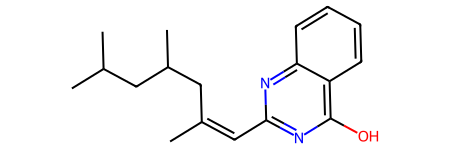

In [39]:
mols[200]

In [40]:
ids[200]

'LTS0118310'

In [38]:
labels_all[200]

'Anthranilate'

In [41]:
import pandas as pd

df = pd.DataFrame({"ID": ids, "SMILES": smiles, "Precursors": labels_all})

In [44]:
df.to_csv("LOTUSDB_predictions.csv", index=False)